<a href="https://colab.research.google.com/github/npr99/PlanningMethods/blob/master/IN_CORE_NeighborhoodCharacteristics_Detailed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Python packages required to read in and Census API data
import requests         # Required for the Census API
import pandas as pd     # For reading, writing and wrangling data
import numpy as np      # For data cleaning
import sys              # For displaying package versions
import geopandas as gpd # For working with geospatial data
import folium as fm     # For making dyamic maps

In [ ]:
# Check python and package versions - important for replicating work
print("Python Version    : ",sys.version)
print("pandas version    : ", pd.__version__)
print("numpy version     : ", np.__version__)
print("geopandas version : ", gpd.__version__)
print("folium version    : ",fm.__version__)

Python Version    :  3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]
pandas version    :  1.0.2
numpy version     :  1.18.2
geopandas version :  0.7.0
folium version    :  0.10.0


# Exploring ACS data at the Block Group level

## Introduction
This Jupyter Notebook (developed using Google Colab) provides an example of obtaining and mapping Block Group Level ACS data.

For more details on the ACS see:
> U.S. Census Bureau. (2018). Understanding and Using American Community Survey Data: What All Data Users Need to Know. U.S. Government Printing Office, Washington, DC. Retrieved from: https://www.census.gov/content/dam/Census/library/publications/2018/acs/acs_general_handbook_2018.pdf

This code is valuable for anyone intersted in using American Community Survey (ACS) data to better understand population and economic characteristics for the United States. This notebook provides background details on the ACS. This notebook uses US Census Application Programming Interface (API) to obtain data. This notebook uses python packages (pandas, geopandas, folium) to clean and explore the obtained data. 

# Motivating example
After working through this notebook, you will have a final dynamic map that shows the new variable based on ACS data at the block group scale.
This map will display after running the entire code. But to provide a motivation the map is included first. If you are running this code for the first time the map may not display. Select `Run all` from the `Runtime` menu above, if the map does not display and then rerun the the first codeblock.

In [ ]:
display(map)

map

# 1. UNDERSTANDING THE ACS: THE BASICS
## What is the ACS?
The American Community Survey (ACS) is a nationwide survey designed to provide communities with reliable and timely social, economic, housing, and
demographic data every year

* The ACS has an annual sample size of about 3.5 million addresses
* Estimates reflect data that have been collected over a period of time
* ACS 1-year estimates are available for geographic areas with at least 65,000 people.
* ACS 5-year estimates are available for all geographic areas 

Because the ACS is based on a sample, rather than all housing units and people, ACS estimates have a degree of uncertainty associated with them, called sampling error. In general, the larger the sample, the smaller the
level of sampling error. To help users understand the impact of sampling error on data reliability, the Census Bureau provides a “margin of error” for each published ACS estimate. The margin of error, combined with the
ACS estimate, give users a range of values within which the actual “real-world” value is likely to fall.

## How are ACS Data Collected?
The ACS collected data using 
1. Internet response
2. Paper questionnaires through the mail
3. Personal visits with a Census Bureau interviewer

The annual sample size of the ACS has increased over
time, from 2.9 million addresses in 2005 to more than
3.5 million addresses in 2015. 

* The survey is not mailed to specific people, but rather to specific addresses
*  The Census Bureau selects a random sample of addresses to be included in the ACS. 
* Each address has about a 1-in-480 chance of being selected in a given month
* No address should be selected more than once every 5 years
* Over a 5-year period, the Census Bureau samples approximately 1-in-9 households nationwide
* The sampling rate is higher in areas with small populations 
* The sampling rate is higher in areas with low predicted response rates


***For more information about the ACS see:***

> U.S. Census Bureau. (2018). Understanding and Using American Community Survey Data: What All Data Users Need to Know. U.S. Government Printing Office, Washington, DC. Retrieved from: https://www.census.gov/content/dam/Census/library/publications/2018/acs/acs_general_handbook_2018.pdf



## Comments about Block Group Level Data
Because the ACS sample sizes get smaller as the geographic area gets smaller, data at the block group level can be probelmatic. Block groups have between 240 and 1,200 housing units (https://www.census.gov/glossary/#term_BlockGroupBG), with a 1-9 sample for a 5-year ACS that means a sample size of between 27 and 333 households. The small sample size leads to a large Margins of Error.


## Helpful links for Census API

https://www.census.gov/data/developers/data-sets/acs-5year.2018.html

https://api.census.gov/data/2018/acs/acs5/variables.html

Working with data.census.gov it is possible to figure out the variables and the exact geography.

After pointing and clicking through data.census.gov one copy the hyperlink for the table:

ACS 5-year table: https://data.census.gov/cedsci/table?g=0500000US48167.150000&tid=ACSDT5Y2013.B19013

Notice that the hyperlink include the details:
* The table id `tid=ACSDT5Y2013.B19013`
* The GEOID for Galveston County, Texas (48167) and Block Groups (150) `g=0500000US48167.150000`

(Available geographies https://api.census.gov/data/2013/acs/acs5/geography.html)

The data can be downloaded. After downloading the data it is possible to see the metadata (or the data about the data). The metadata provides the details about each variable.





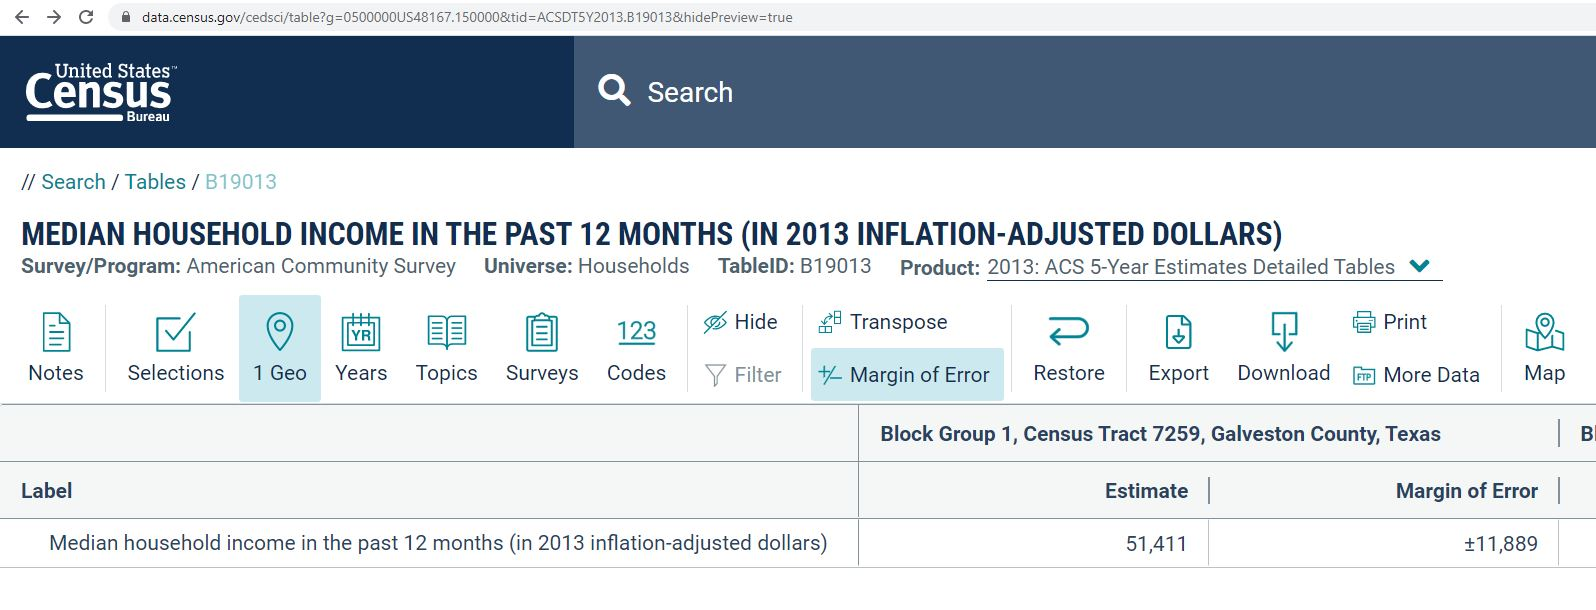

## The downloaded metadata file look will look like this screenshot:

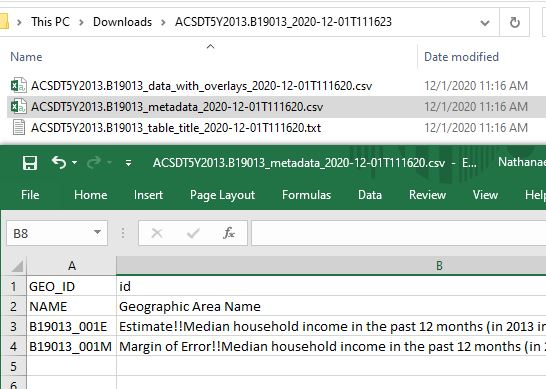

For example the first variable is NAME - which refers to the Geographic Area Name.
NAME	Geographic Area Name

The first variable is `B19013_001E` which provides the Mediain household income estimate. 

`B19013_001E	Estimate!!Median household income in the past 12 months (in 2013 inflation-adjusted dollars)`

The variable provides the margin of error for the Median Income.

# API Code to obtain block group level data

## Step 1: Obtain Data
This example uses the Census API to get all the block groups for an individual county. (`state:48_county:167`). The api request could be modified to get all the data for the entire state, but this would be a very large file to work with.

## What county and year do you want for the data?
For this you will need to find the 5 digit county fips code.

For a full list of County FIPS codes: https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697 

Examples: Brazos County, Texas = 48041 (state = '48', county = '167')

Notice that the leading 0 must be included.

The year corresponds to the 5 year ACS.
For example, 2013 means the years 2009-2013 5-year ACS.

In [ ]:
state    = '48'     # State FIPS Code   
# List of County FIPS Codes within the same state
counties = ['167','041']
acs_year = '2013'   # ACS Year
srvy     = '5'      # 5-year or 1-year ACS Single-Year or Multiyear Estimates

# Variables to get
get_vars = ['B19013','B03002'] 
# B03002 = HISPANIC OR LATINO ORIGIN BY RACE, 
# B19013 = Median Household Income

In [ ]:
# Create dictionary to store dataframes with Census Data
acs_blockgroup = {}
  
# loop through variables to get
for var in get_vars:
    print(var)
    
    # loop through counties
    appended_countydata = []  # start an empty container for the county data
    for county in counties:
        print(county)

        # Set up hyperlink for Census API
        api_hyperlink_part1 = 'https://api.census.gov/data/'+acs_year+'/acs/acs'+srvy+'?get=group('+var+')'
        api_hyperlink_part2 = '&in=state:'+state+'+county:'+county+'&for=block%20group:*'
        api_hyperlink = api_hyperlink_part1 + api_hyperlink_part2
        print("Census API data from: "+ api_hyperlink)

        # Obtain Census API Data
        apijson = requests.get(api_hyperlink)
        # Convert the requested json into pandas dataframe
        apidf = pd.DataFrame(columns=apijson.json()[0], data=apijson.json()[1:])
        appended_countydata.append(apidf)
        

    acs_blockgroup[var] = pd.concat(appended_countydata)
    
    # Add variable that identifies ACS year and survey period
    acs_blockgroup[var]['Survey'] = 'ACS'+acs_year+' '+srvy+'-year'

B19013
167
Census API data from: https://api.census.gov/data/2013/acs/acs5?get=group(B19013)&in=state:48+county:167&for=block%20group:*
041
Census API data from: https://api.census.gov/data/2013/acs/acs5?get=group(B19013)&in=state:48+county:041&for=block%20group:*
B03002
167
Census API data from: https://api.census.gov/data/2013/acs/acs5?get=group(B03002)&in=state:48+county:167&for=block%20group:*
041
Census API data from: https://api.census.gov/data/2013/acs/acs5?get=group(B03002)&in=state:48+county:041&for=block%20group:*


In [ ]:
# B19013 = Median Household Income
acs_blockgroup['B19013'].head()

,GEO_ID,B19013_001E,B19013_001M,NAME,B19013_001MA,B19013_001EA,state,county,tract,block group,Survey
0,1500000US481677259001,51411,11889,"Block Group 1, Census Tract 7259, Galveston Co...",None,None,48,167,725900,1,ACS2013 5-year
1,1500000US481677259002,43231,11257,"Block Group 2, Census Tract 7259, Galveston Co...",None,None,48,167,725900,2,ACS2013 5-year
2,1500000US481677260001,95257,21443,"Block Group 1, Census Tract 7260, Galveston Co...",None,None,48,167,726000,1,ACS2013 5-year
3,1500000US481677260002,74583,39157,"Block Group 2, Census Tract 7260, Galveston Co...",None,None,48,167,726000,2,ACS2013 5-year
4,1500000US481677261001,71597,13841,"Block Group 1, Census Tract 7261, Galveston Co...",None,None,48,167,726100,1,ACS2013 5-year


In [ ]:
acs_blockgroup['B03002'].head()

,GEO_ID,B03002_001E,B03002_001M,B03002_002E,B03002_002M,B03002_003E,B03002_003M,B03002_004E,B03002_004M,B03002_005E,...,B03002_019EA,B03002_020EA,B03002_020MA,B03002_021EA,B03002_021MA,state,county,tract,block group,Survey
0,1500000US481677259001,602,191,529,182,417,153,57,43,0,...,None,None,None,None,None,48,167,725900,1,ACS2013 5-year
1,1500000US481677259002,1779,411,1414,383,1199,351,102,100,0,...,None,None,None,None,None,48,167,725900,2,ACS2013 5-year
2,1500000US481677260001,922,144,770,158,663,141,53,71,0,...,None,None,None,None,None,48,167,726000,1,ACS2013 5-year
3,1500000US481677260002,649,211,623,217,609,216,0,13,10,...,None,None,None,None,None,48,167,726000,2,ACS2013 5-year
4,1500000US481677261001,1462,255,1282,244,1263,244,7,12,12,...,None,None,None,None,None,48,167,726100,1,ACS2013 5-year


In [ ]:
acs_blockgroup['B03002'][['GEO_ID','state','county']].describe()

,GEO_ID,state,county
count,312,312,312
unique,312,1,2
top,1500000US481677246001,48,167
freq,1,312,194


# Step 2: Data cleaning
In this step we will clean the data file.
Currently the Median Income Data is stored as a string and needs to be converted to a number.

In [ ]:
### 2.1 Set the variable type
acs_blockgroup["B19013_001E"] = acs_blockgroup["B19013_001E"].astype(int)
acs_blockgroup["B19013_001M"] = acs_blockgroup["B19013_001M"].astype(int)

In [ ]:
pd.option_context('float_format', '{:,.0f}'.format)
acs_blockgroup[['B19013_001E','B19013_001M']].describe()

,B19013_001E,B19013_001M
count,194.00,194.00
mean,-3379371.41,-1125289.24
std,47868003.85,15956087.98
min,-666666666.00,-222222222.00
25%,34398.50,10378.00
50%,51390.00,17389.50
75%,74388.75,27606.00
max,145104.00,86074.00


## Replace Missing Data Codes
Notice that missing data is flagged as -666666666 and -222222222.
The details of these codes can be found in the Notes tab on data.census.gov

1. Estimate value = -222222222, Annotation Value = ''**''
> An ''**'' entry in the margin of error column indicates that either no sample observations or too few sample observations were available to compute a standard error and thus the margin of error. A statistical test is not appropriate.
2. Estimate value = -666666666, Annotation Value = ''-'' 
> An ''-'' entry in the estimate column indicates that either no sample observations or too few sample observations were available to compute an estimate, or a ratio of medians cannot be calculated because one or both of the median estimates falls in the lowest interval or upper interval of an open-ended distribution.

List of Annotation Values:

https://www.census.gov/data/developers/data-sets/acs-1year/notes-on-acs-estimate-and-annotation-values.html

To explore these Block Groups the next command will locate (.loc) observations where the median income is missing. The sample size variable (`B00002_001E`) will indicate how many housing units were surveyed in the block group.

For more deatilas on the variables:
* https://api.census.gov/data/2013/acs/acs5/variables/B19013_001MA.html
* https://api.census.gov/data/2013/acs/acs5/variables/B00002_001E.html


In [ ]:
acs_blockgroup.loc[acs_blockgroup['B19013_001E']==-666666666]

,GEO_ID,B00002_001E,GEO_ID,B19013_001E,B19013_001M,NAME,B19013_001MA,B19013_001EA,state,county,tract,block group
8,1500000US481679900000,0,1500000US481679900000,-666666666,-222222222,"Block Group 0, Census Tract 9900, Galveston Co...",**,-,48,167,990000,0


### Replace missing data with missing values
Currently python sees the missing data as a very large negative value (-666666666 and -222222222). These values need to be replaced with an empty cell or a missing value. The numpy package provides a command to make the replacement.

In [ ]:
# in the data frame locate the observations and replace the varaible with the new value
acs_blockgroup.loc[acs_blockgroup['B19013_001E']==-666666666, 'B19013_001E'] = np.nan
acs_blockgroup.loc[acs_blockgroup['B19013_001M']==-222222222, 'B19013_001M'] = np.nan

# Check cleaned variables
acs_blockgroup[['B19013_001E','B19013_001M']].describe()

,B19013_001E,B19013_001M
count,193.00,193.00
mean,57350.33,20290.73
std,29662.03,13237.38
min,9838.00,1360.00
25%,34613.00,10486.00
50%,51411.00,17508.00
75%,74583.00,27615.00
max,145104.00,86074.00


In [ ]:
# Add GEOID for merge with shapefile
acs_blockgroup['GEOID10'] = acs_blockgroup['state'] + acs_blockgroup['county'] + acs_blockgroup['tract'] + acs_blockgroup['block group']
acs_blockgroup['GEOID10'].describe()

count              194
unique             194
top       481677240001
freq                 1
Name: GEOID10, dtype: object

## Step 3: Explore Data
This section will create a dynamic map to spatially explore the data


In [ ]:
# packages required for dyanmic mapping
# Need to upgrade to folium 0.11.0
!pip install --upgrade folium

     |████████████████████████████████| 102kB 6.9MB/s ta 0:00:011
  Found existing installation: folium 0.10.0
    Uninstalling folium-0.10.0:
      Successfully uninstalled folium-0.10.0
  Rolling back uninstall of folium
  Moving to /home/jupyter/.local/lib/python3.6/site-packages/folium-0.10.0.dist-info/
   from /home/jupyter/.local/lib/python3.6/site-packages/~olium-0.10.0.dist-info
  Moving to /home/jupyter/.local/lib/python3.6/site-packages/folium/
   from /home/jupyter/.local/lib/python3.6/site-packages/~olium
ERROR: Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/opt/conda/lib/python3.6/site-packages/folium'
Consider using the `--user` option or check the permissions.



In [ ]:
from folium import plugins # Add minimap and search plugin functions to maps

In [ ]:
# These lines of code download the shapefile, unzip the files, and creates 
# Geopandas dataframe
filename = 'tl_2010_48167_bg10'
!wget -o -q https://www2.census.gov/geo/tiger/TIGER2010/BG/2010/{filename}.zip
!unzip -o -q {filename}.zip
bg_gdf = gpd.read_file(f'{filename}.shp')
bg_gdf = gdf.to_crs(epsg=4326)

In [ ]:
bg_gdf.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLKGRPCE10,GEOID10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,48,167,721100,1,481677211001,Block Group 1,G5030,S,1640415,0,+29.4682045,-095.0443214,"POLYGON ((-95.04689 29.47437, -95.04688 29.474..."
1,48,167,721700,6,481677217006,Block Group 6,G5030,S,8050038,821869,+29.4977533,-094.9668808,"POLYGON ((-94.98777 29.49871, -94.98804 29.499..."
2,48,167,723300,3,481677233003,Block Group 3,G5030,S,11166322,34870,+29.4200323,-095.0664642,"POLYGON ((-95.09214 29.41645, -95.09214 29.416..."
3,48,167,723300,2,481677233002,Block Group 2,G5030,S,11392867,116005,+29.4077955,-095.0579598,"POLYGON ((-95.04170 29.41157, -95.04065 29.410..."
4,48,167,723502,1,481677235021,Block Group 1,G5030,S,20809126,55323,+29.3824596,-095.1551923,"POLYGON ((-95.14947 29.34039, -95.15074 29.342..."


## Merge new ACS proportion varaible with GDF

In [ ]:
# merge bg_gdf with acs_blockgroup on GEOID10
# the shapefile (bg_gdf) is the "left side"
# the new ACS variable data (acs_blockgroup) is the "right side"
acs_bg_gdf_merged = bg_gdf.merge(acs_blockgroup[['GEOID10','B19013_001E','B19013_001M']],
                                 left_on='GEOID10', right_on='GEOID10')
# Check to make sure the merge worked correctly
acs_bg_gdf_merged[['GEOID10','B19013_001E','B19013_001M','geometry']].head()

,GEOID10,B19013_001E,B19013_001M,geometry
0,481677211001,65089.00,32906.00,"POLYGON ((-95.04689 29.47437, -95.04688 29.474..."
1,481677217006,87168.00,18150.00,"POLYGON ((-94.98777 29.49871, -94.98804 29.499..."
2,481677233003,102344.00,35055.00,"POLYGON ((-95.09214 29.41645, -95.09214 29.416..."
3,481677233002,92083.00,23424.00,"POLYGON ((-95.04170 29.41157, -95.04065 29.410..."
4,481677235021,83958.00,13543.00,"POLYGON ((-95.14947 29.34039, -95.15074 29.342..."


In [ ]:
# What location should the map be centered on?
center_x = (acs_bg_gdf_merged.bounds.minx.mean() + acs_bg_gdf_merged.bounds.maxx.mean())/2
center_y = (acs_bg_gdf_merged.bounds.miny.mean() + acs_bg_gdf_merged.bounds.maxy.mean())/2
print(f'The center of the map data file is located at {center_x} {center_y}')

# How should the map be bound - look for the southwest and northeast corners of the data
sw_corner = [acs_bg_gdf_merged.bounds.miny.min(),acs_bg_gdf_merged.bounds.minx.min()]
ne_corner = [acs_bg_gdf_merged.bounds.maxy.max(),acs_bg_gdf_merged.bounds.maxx.max()]
print(f'The map data file is bounded by at {sw_corner} {ne_corner}')

# What styles and highlight options do you want?
style_function1 = lambda x: {
            'fillColor': 'transparent',
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.25
        }

highlight_function1 = lambda x: {'fillOpacity': 0.5}


# Time to make the map:
map = fm.Map(location=[center_y, center_x], 
    max_bounds = True,
    control_scale=True,
    prefer_canvas=True)

# Add cholorpleth layer:
fm.Choropleth(
    geo_data = acs_bg_gdf_merged,
    data=acs_bg_gdf_merged,
    columns=['GEOID10','B19013_001E'],
    key_on= 'feature.properties.GEOID10',
    fill_color='YlGnBu',
    name = 'Median Income ($), '+ acs_year + ' 5-year ACS',
    legend_name= 'Median Income ($)'
).add_to(map)

# Add Block group layer - this allows for search
# not available in folium 0.10.0
#searchlayer = fm.GeoJson( 
#        acs_bg_gdf_merged.to_json(),
#        name= 'Block Group Map',
#        style_function=style_function1,
#        highlight_function=highlight_function1,
#        tooltip=fm.features.GeoJsonTooltip(fields=['GEOID10', 'B19013_001E'], sticky=False) ,
#        popup= fm.GeoJsonPopup(
#            fields=['GEOID10','B19013_001E']
#        )
#    ).add_to(map)

fm.LayerControl(collapsed=False, autoZIndex=False).add_to(map)

# Add minimap
plugins.MiniMap().add_to(map)

# Add search function
# not available in folium 0.10.0
#plugins.Search(searchlayer,position='topleft',
#                        search_zoom=15,
#                        search_label='GEOID10',
#                        geom_type='Polygon').add_to(map)

map.fit_bounds([sw_corner, ne_corner])

map.save(filename+'meidianincome.html')
#files.download(f'output_maplayers/{mapname}.html')

The center of the map data file is located at -94.96170002319587 29.394953239690718
The map data file is bounded by at [29.062738999999997, -95.233081] [29.598264, -94.369361]


In [ ]:
display(map)

# Check data with Census Reporter

Census Reporter is a great tool for getting to explore ACS data.
Lets compare the results from this notebook with Census Reporter for the census block group with the lowest median income.

First lets find the county with the highest percentage.

In [ ]:
# lowest median income
min_value = acs_blockgroup['B19013_001E'].min()
min_value

9838.0

In [ ]:
varlist = ['GEOID10','B19013_001E','B19013_001M']
block_group = acs_blockgroup[varlist].loc[acs_blockgroup['B19013_001E'] == min_value].melt()
block_group

,variable,value
0,GEOID10,481677246002
1,B19013_001E,9838.00
2,B19013_001M,4222.00


In [ ]:
GEOID = block_group.iloc[0]['value']
GEOID

'481677246002'

In [ ]:
# Create Census Reporter link
census_reporter_link = 'https://censusreporter.org/profiles/15000US'+GEOID+'/'
display('Use the following link to compare results to Census Reporter')
census_reporter_link

'Use the following link to compare results to Census Reporter'

'https://censusreporter.org/profiles/15000US481677246002/'

Comparing the results with Census Reporter shows an accurate match. The comparison provides a means to validate the workflow. Census Reporter also provides more details about the unique geography.